In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from scipy.signal import butter, filtfilt

In [ ]:
data = torch.load('eeg_signals_raw_with_mean_std.pth', weights_only=False)

In [3]:
print(f"Top-level type: {type(data)}")

if isinstance(data, dict):
    for k, v in data.items():
        if hasattr(v, 'shape'):
            print(f"{k}: shape = {v.shape}")
        elif isinstance(v, list):
            print(f"{k}: list with length = {len(v)}; first element type = {type(v[0])}")
            if hasattr(v[0], 'shape'):
                print(f"    First element shape = {v[0].shape}")
        else:
            print(f"{k}: type = {type(v)}")
else:
    print("Not a dict. Top-level object:", type(data))


Top-level type: <class 'dict'>
dataset: list with length = 11965; first element type = <class 'dict'>
labels: list with length = 40; first element type = <class 'str'>
images: list with length = 1996; first element type = <class 'str'>
means: shape = torch.Size([128, 1])
stddevs: shape = torch.Size([128, 1])


In [4]:
fs = 1000     
lowcut = 5     
highcut = 95    

def bandpass_filter(signal, lowcut, highcut, fs, order=5): #order controls the distortion of the filter
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal, axis=-1)

filtered_dataset = []

for sample in data['dataset']:
    eeg = sample['eeg'].numpy()  # shape [128, 500]
    eeg_filtered = bandpass_filter(eeg, lowcut, highcut, fs)
    new_sample = sample.copy()
    new_sample['eeg'] = torch.tensor(eeg_filtered.copy(), dtype=torch.float32)
    filtered_dataset.append(new_sample)

data['filtered_dataset'] = filtered_dataset
# torch.save(data, 'filtered_eeg_data.pth')

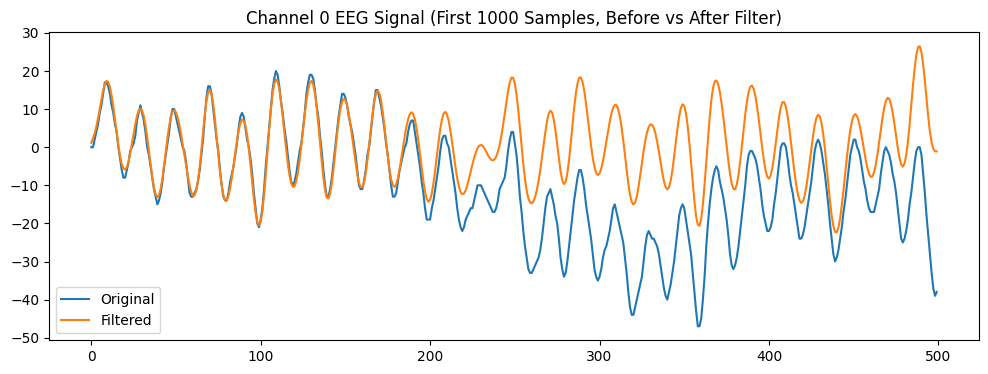

In [5]:
orig = data['dataset'][0]['eeg'][0].numpy()
filt = data['filtered_dataset'][0]['eeg'][0].numpy()
plt.figure(figsize=(12, 4))
plt.plot(orig[:1000], label='Original')
plt.plot(filt[:1000], label='Filtered')
plt.legend()
plt.title("Channel 0 EEG Signal (First 1000 Samples, Before vs After Filter)")
plt.show()

In [6]:
def normalize_channels(epoch, means=None, stddevs=None):
    """
    Args:
        epoch: np.ndarray or torch.Tensor, shape [128, T]
        means: torch.Tensor or np.ndarray, shape [128, 1] 
        stddevs: torch.Tensor or np.ndarray, shape [128, 1] 
    Returns:
        torch.Tensor: normalized epoch [128, T]
    """
    if not isinstance(epoch, torch.Tensor):
        epoch = torch.tensor(epoch.copy(), dtype=torch.float32)
    if means is None or stddevs is None:
        # Compute from this epoch if not provided
        means = epoch.mean(dim=1, keepdim=True)
        stddevs = epoch.std(dim=1, keepdim=True)
    else:
        if isinstance(means, np.ndarray):
            means = torch.tensor(means, dtype=epoch.dtype)
        if isinstance(stddevs, np.ndarray):
            stddevs = torch.tensor(stddevs, dtype=epoch.dtype)
        
    stddevs = stddevs.clone()
    stddevs[stddevs == 0] = 1e-6
    return (epoch - means) / stddevs

def pad_channels_to_128(epoch):
    num_channels = epoch.shape[0]
    if num_channels == 128:
        return epoch
    elif num_channels < 128:
        reps = 128 // num_channels + 1
        padded = np.tile(epoch, (reps, 1))[:128, :]
        return padded
    else:
        return epoch[:128, :]

In [ ]:
for sample in filtered_dataset:
    eeg = sample['eeg'].numpy()
    eeg_padded = pad_channels_to_128(eeg)
    sample['eeg'] = torch.tensor(eeg_padded, dtype=torch.float32)

for sample in filtered_dataset:
    eeg = sample['eeg'].numpy()
    eeg_norm = normalize_channels(eeg)
    sample['eeg'] = eeg_norm.clone().detach().float()
        
    # Breaks the tensor from the computation graph because here we are not training a model, just preprocessing data


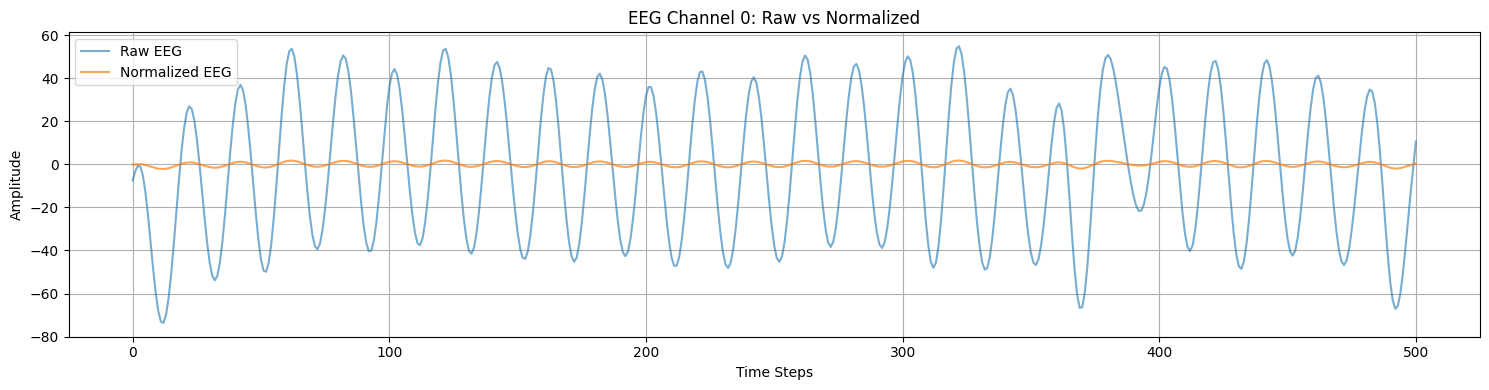

In [8]:
# Plotting
plt.figure(figsize=(15, 4))
plt.plot(eeg_padded[0], label='Raw EEG', alpha=0.6)
plt.plot(eeg_norm[0], label='Normalized EEG', alpha=0.7)
plt.title(f'EEG Channel {0}: Raw vs Normalized')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
class TemporalTokenizer(nn.Module):
    def __init__(self, in_channels=128, steps_per_token=4, embed_dim=1024):
        super().__init__()
        self.steps_per_token = steps_per_token
        self.in_dim = in_channels * steps_per_token
        self.embed_dim = embed_dim
        self.projection = nn.Linear(self.in_dim, embed_dim)

    def forward(self, eeg):
        """
        eeg: Tensor of shape [B, C, T] where B = 11964, C = 128, T = time steps
        """
        B, C, T = eeg.shape
        assert T % self.steps_per_token == 0, "Time steps must be divisible by steps_per_token"

        num_tokens = T // self.steps_per_token
        eeg = eeg.view(B, C, num_tokens, self.steps_per_token)  # [B, 128, num_tokens, 4]
        # reshape a tensor without changing its underlying data
        eeg = eeg.permute(0, 2, 1, 3).contiguous()  
        # [B, num_tokens, 128, 4] , Rearranging dimensions and making it contiguous in memory for the next view operation
        tokens = eeg.view(B, num_tokens, -1)  # [B, num_tokens, 512]   

        embedded_tokens = self.projection(tokens)  # [B, num_tokens, 1024]
        return embedded_tokens


In [ ]:
length = 532  # max length
eeg_signals_m = []
for sample in data['filtered_dataset']:
    eeg = sample['eeg'].detach().cpu().numpy()  
    # shape: [128, T] ,  NUMPY() CAN ONLY BE USED ON CPU thus we need to detach it from the GPU

    if eeg.shape[1] < length:
        pad_width = length - eeg.shape[1]
        eeg = np.pad(eeg, ((0, 0), (0, pad_width)), mode='constant') # using zero constant padding
    elif eeg.shape[1] > length:
        eeg = eeg[:, :length]

    eeg_signals_m.append(eeg)

eeg_data_array = np.stack(eeg_signals_m)
print(eeg_data_array.shape)


(11965, 128, 532)


In [ ]:
batch_size = 128  # Number of samples to process in each batch
tokens_list = []

eeg_tensor = torch.tensor(eeg_data_array, dtype=torch.float32)
tokenizer = TemporalTokenizer(in_channels=128, steps_per_token=4, embed_dim=1024)

for i in range(0, eeg_tensor.shape[0], batch_size):
    batch = eeg_tensor[i:i+batch_size]  # [batch_size, 128, 532]
    with torch.no_grad():  # saves memory if not training as it tells the computer not to track gradients
        batch_tokens = tokenizer(batch)
    tokens_list.append(batch_tokens)

# Concatenate all tokens
tokens = torch.cat(tokens_list, dim=0)  # [11964, 133, 1024]


In [12]:
def compute_fft(eeg_epoch, fs=1000):
    """
    Args:
        eeg_epoch (Tensor or ndarray): EEG data [128, T]
        fs (int): Sampling frequency
    """
    if isinstance(eeg_epoch, torch.Tensor):
        eeg_np = eeg_epoch.numpy()
    else:
        eeg_np = eeg_epoch

    n = eeg_np.shape[1]
    fft_vals = np.fft.rfft(eeg_np, axis=1)
    fft_mag = np.abs(fft_vals) / n
    freqs = np.fft.rfftfreq(n, d=1/fs)

    return freqs, fft_mag    

In [13]:
def plot_fft_spectrum(freqs, fft_magnitude, channel=0):
    plt.figure(figsize=(10, 4))
    plt.plot(freqs, fft_magnitude[channel])
    plt.title(f'FFT Magnitude Spectrum - Channel {channel}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.xlim(0, 200)  
    plt.grid(True)
    plt.show()

In [14]:
def plot_spectrogram(eeg_epoch, channel=0, fs=1000, nperseg=256, noverlap=128):  
    """
    * mainly using STFT
    * overlap brings smoothness
    * frequency resolution of about 4Hz is needed for EEG data to distinguish between alpha, beta, and gamma waves

    Args:
        nperseg (int): Length of each FFT window
        noverlap (int): Number of overlapping samples per window
    """
    signal = eeg_epoch[channel].numpy()

    plt.figure(figsize=(10, 6))
    plt.specgram(signal, NFFT=nperseg, Fs=fs, noverlap=noverlap, scale='dB', cmap='viridis')
    # NFFT is no. of points in each segment for frequency resolution

    plt.title(f'Spectrogram - Channel {channel}')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar(label='Power (dB)')
    plt.ylim(0, 200)
    plt.tight_layout()
    plt.show()


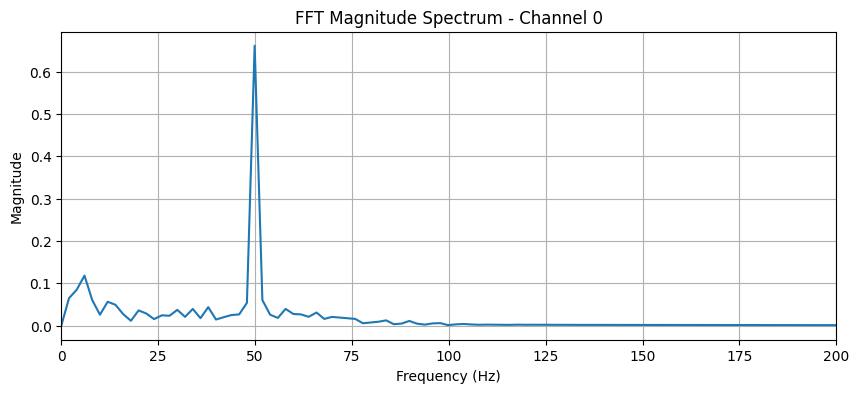

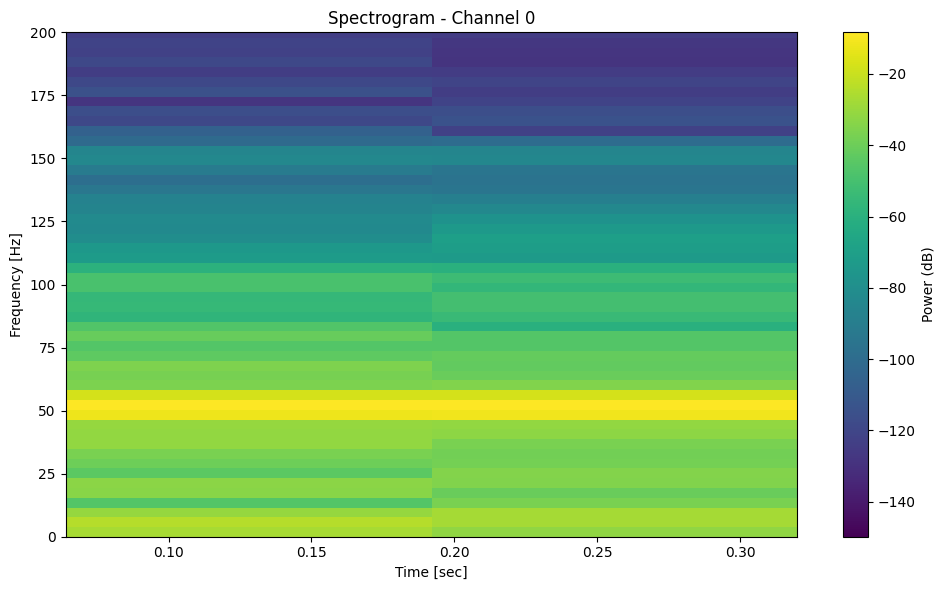

In [15]:
example_epoch = sample['eeg']  # shape [128, T]
freqs, fft_mag = compute_fft(example_epoch)
plot_fft_spectrum(freqs, fft_mag, channel=0)
plot_spectrogram(example_epoch, channel=0)